In [1]:
# Mount Google Drive untuk membaca file CSV
import os
from google.colab import drive
drive.mount('/content/drive')

loc = '/content/drive/My Drive/Spark ITB'
os.chdir(loc)

os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Spark ITB'

In [2]:
# Install XGBoost jika belum terinstall
!pip install xgboost scikit-learn matplotlib
!pip install pandas
!pip install optuna
!pip install rasterio
!pip install numpy
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 60.5 MB/s eta 0:00:00


In [3]:
# Import library yang diperlukan
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [4]:
file_path = '/content/drive/MyDrive/Spark ITB/ADA BINERNYA_UKMNCT_IIoT_FDIA_converted.xlsx'

In [5]:
# Membaca file CSV atau Excel
if file_path.endswith('.csv'):
    data = pd.read_csv(file_path)
else:
    data = pd.read_excel(file_path)

In [6]:
# Tampilkan beberapa baris awal data untuk memastikan
print(data.head())

   http_response_body_len  dst_port  dns_rcode  dns_qclass  dns_qtype  \
0                0.019536  0.086357   0.495797    0.041017   0.194625   
1                0.019536  0.188415   0.484033    0.047996   0.212062   
2                0.019536  0.086357   0.495797    0.041017   0.194625   
3                0.019536  0.188415   0.484033    0.047996   0.212062   
4                0.019535  0.004710   0.505208    0.035434   0.180676   

   src_port  http_resp_mime_types  http_request_body_len  conn_state  \
0  0.183797                   0.7               0.880951    0.217391   
1  0.394561                   0.7               0.880955    0.217391   
2  0.183797                   0.7               0.880951    0.217391   
3  0.394561                   0.7               0.880955    0.217391   
4  0.015186                   0.7               0.880948    0.217391   

   http_user_agent  ...     proto  dns_rejected  dns_RA  dns_RD  dns_AA  \
0         0.972222  ...  0.416667           1.0     1

# Pre-processing dan feature engineering


In [7]:

X = data[['http_response_body_len', 'dst_port', 'dns_rcode', 'dns_qclass', 'dns_qtype',
          'src_port', 'http_resp_mime_types', 'http_request_body_len', 'conn_state',
          'http_user_agent', 'ssl_issuer', 'ssl_subject', 'http_orig_mime_types', 'http_trans_depth',
          'http_method', 'http_status_code', 'http_version', 'http_uri','ssl_cipher', 'ssl_version', 'ssl_resumed',
          'ssl_established', 'proto', 'dns_rejected', 'dns_RA', 'dns_RD', 'dns_AA', 'service', 'dns_query', 'dst_ip_bytes']]  # variabel X (independen) #sesuaikan kolom sebagai variabel independen nya


y = data[['binary_marker']]


In [8]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (15425, 30)
Shape of y: (15425, 1)


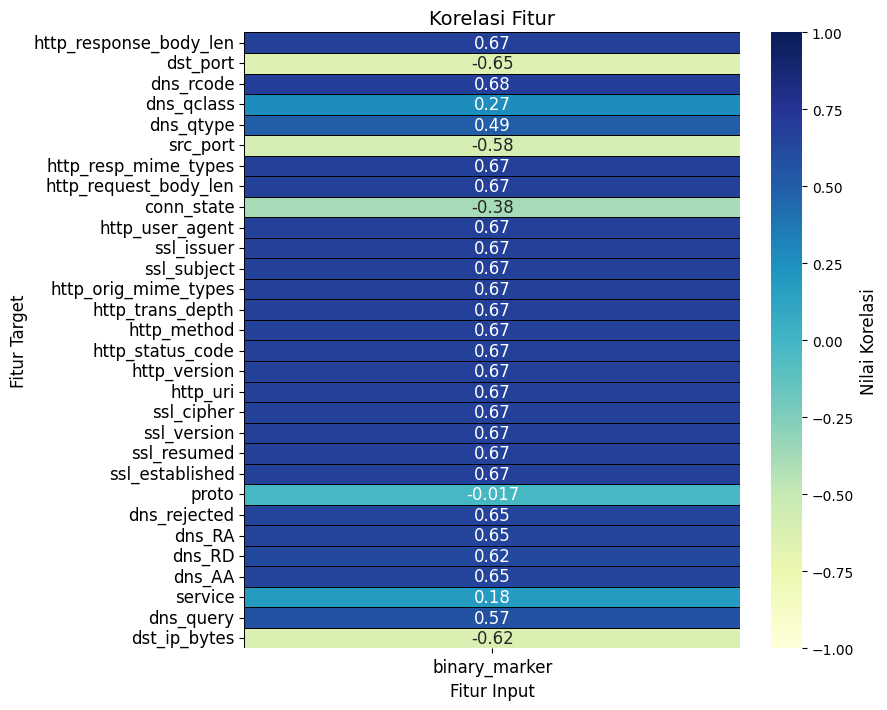

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations between each column in X and each column in y
correlations = {}
for target in y.columns:
    correlations[target] = [X[col].corr(y[target]) for col in X.columns]

# Convert to DataFrame for visualization
correlation_df = pd.DataFrame(correlations, index=X.columns)

# Plot heatmap with font size adjustments
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(correlation_df, annot=True, cmap='YlGnBu', center=0, cbar=True, vmin=-1, vmax=1,
                      annot_kws={"size": 12}, linewidths=0.5, linecolor='black')  # Set annotation font size to 12

# Adjust colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Nilai Korelasi", fontsize=12)  # Set color bar label font size

# Set title and labels with font size adjustments
plt.title("Korelasi Fitur", fontsize=14)
plt.xlabel("Fitur Input", fontsize=12)
plt.ylabel("Fitur Target", fontsize=12)

# Set tick label font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


# untuk Classifier

In [15]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fungsi objektif untuk optimasi parameter, termasuk random_state
def objective(trial):
    # Memilih random_state dalam rentang yang diinginkan (0 hingga 150)
    random_state = trial.suggest_int('random_state', 0, 150)

    # Pisahkan data menjadi training dan testing set berdasarkan random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state, shuffle=True)

    # Parameter tuning untuk model XGBoost
    param = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Inisialisasi model XGBoost dengan parameter
    xg_model = xgb.XGBClassifier(**param, use_label_encoder=False, eval_metric='logloss')
    xg_model.fit(X_train, y_train)

    # Prediksi pada data testing
    y_test_pred = xg_model.predict(X_test)
    y_test_pred_prob = xg_model.predict_proba(X_test)[:, 1]

    # Hitung metrik evaluasi utama
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc_roc = roc_auc_score(y_test, y_test_pred_prob)

    # Evaluasi overfitting berdasarkan training set
    y_train_pred = xg_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)

    # Deteksi overfitting jika akurasi training jauh lebih tinggi dari testing
    if accuracy_train - accuracy > 0.1:
        return -float('inf')  # Penalti jika overfitting

    # Optimasi berdasarkan F1-Score (atau metrik lain jika diperlukan)
    return f1

# Membuat studi Optuna dan optimasi untuk mendapatkan parameter terbaik
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Anda dapat menambah atau mengurangi n_trials sesuai kebutuhan

# Menampilkan parameter terbaik yang ditemukan, termasuk random_state
print("Best parameters including random_state:", study.best_params)
print("Best F1-Score (testing):", study.best_value)

# Evaluasi model terbaik dengan parameter dan random_state terbaik
best_params = study.best_params
random_state_best = best_params.pop("random_state")  # Mengambil random_state terbaik dari hasil parameter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state_best, shuffle=True)
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Prediksi pada data testing
y_test_pred = best_model.predict(X_test)
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

# Evaluasi overfitting berdasarkan training set
y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

print("\nEvaluasi Akhir Model Terbaik:")
print(f"Accuracy (Training): {accuracy_train:.4f}")
print(f"Accuracy (Testing): {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Periksa apakah model overfitting
if accuracy_train - accuracy > 0.1:
    print("Model tidak digunakan karena terdeteksi overfitting.")
else:
    print("Model memenuhi kriteria dan dapat digunakan.")



[I 2025-01-06 15:35:03,754] A new study created in memory with name: no-name-3146d702-36f5-40b9-85bb-070f6150e609
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:35:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-06 15:35:04,204] Trial 0 finished with value: 0.9814402375649591 and parameters: {'random_state': 101, 'max_depth': 1, 'learning_rate': 0.07740911442266064, 'n_estimators': 288, 'subsample': 0.6077859397795229, 'colsample_bytree': 0.7431361929121169, 'reg_alpha': 0.5426321132763174, 'reg_lambda': 0.3113096648697805, 'min_child_weight': 3}. Best is trial 0 with value: 0.9814402375649591.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:35:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-01-06 15:35:05,020] Trial 1 finished with value: 0.99

Best parameters including random_state: {'random_state': 118, 'max_depth': 5, 'learning_rate': 0.12488053558371146, 'n_estimators': 216, 'subsample': 0.626560431730419, 'colsample_bytree': 0.843534889424173, 'reg_alpha': 0.03648204172054992, 'reg_lambda': 0.3632863557365079, 'min_child_weight': 2}
Best F1-Score (testing): 0.9984962406015038

Evaluasi Akhir Model Terbaik:
Accuracy (Training): 0.9979
Accuracy (Testing): 0.9987
Precision: 0.9985
Recall: 0.9985
F1-Score: 0.9985
AUC-ROC: 1.0000
Model memenuhi kriteria dan dapat digunakan.


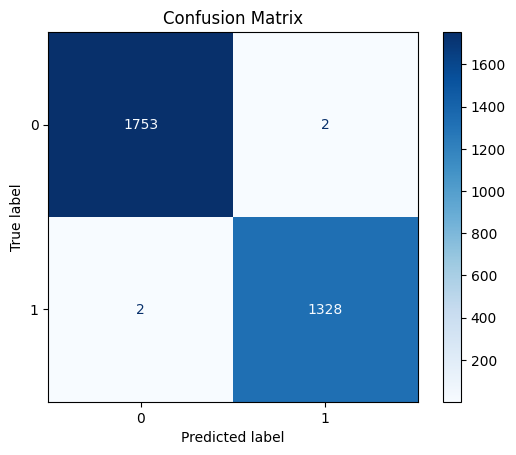

<ipython-input-16-467eea0f68cf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metrics, palette="viridis")


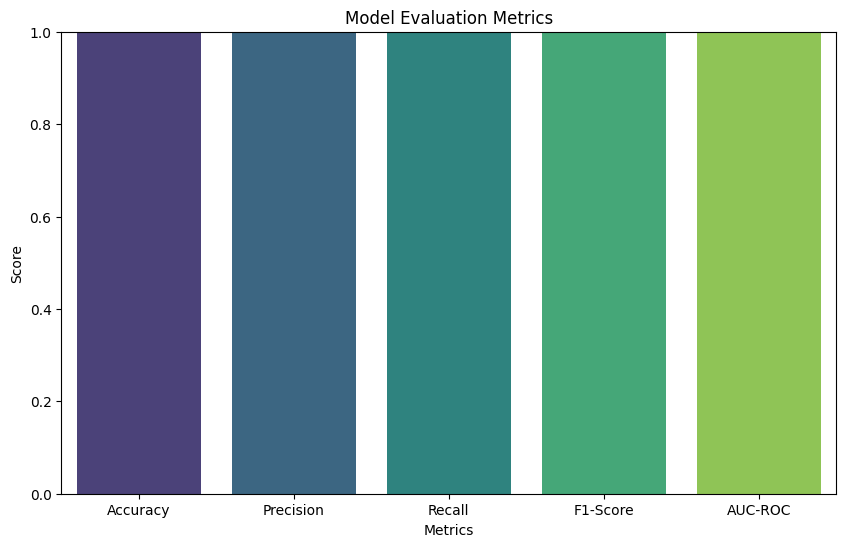

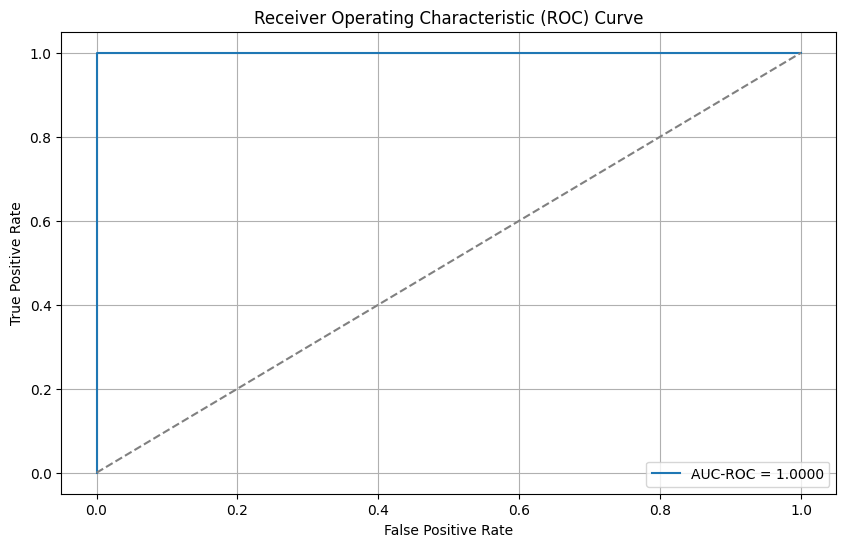

In [16]:
# Matriks Konfusi
conf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Grafik Evaluasi
metrics = [accuracy, precision, recall, f1, auc_roc]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]

plt.figure(figsize=(10, 6))
sns.barplot(x=metric_names, y=metrics, palette="viridis")
plt.ylim(0, 1)
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.show()

# Plot AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

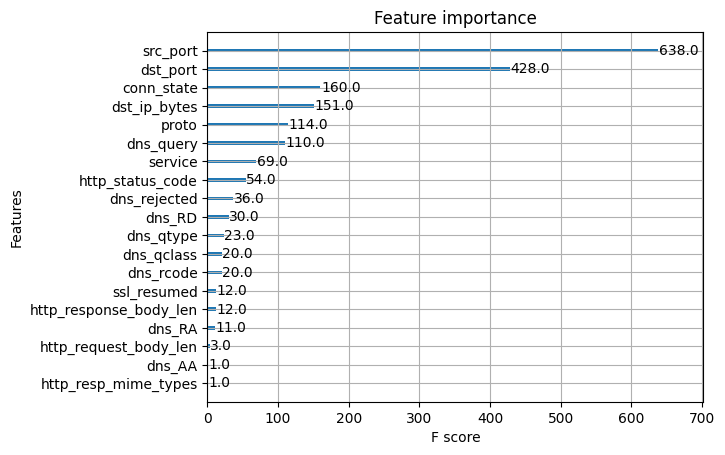

In [17]:
# Feature Importance
xgb.plot_importance(best_model, importance_type="weight")
plt.show()

# Menyimpan Hasil Model

In [23]:
from sklearn.metrics import classification_report

# 5. Membandingkan Hasil Prediksi dengan Nilai Aktual
results = pd.DataFrame({
    'Actual_lab': y_test.values.flatten(),
    'Predicted': y_test_pred
})

pd.set_option('display.max_columns', None)  # Menampilkan semua kolom
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.expand_frame_repr', False)  # Tidak memotong tampilan menjadi beberapa baris
print(results)

results.to_excel('/content/drive/MyDrive/Spark ITB/HASIL PREDIKSI SPARK ITB.xlsx', index=False)

# 7. Menampilkan Hasil Evaluasi
print("Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# 8. Menampilkan Dataframe Hasil
print(results.head())

      Actual_lab  Predicted
0              0          0
1              0          0
2              0          0
3              1          1
4              0          0
5              0          0
6              1          1
7              1          1
8              1          1
9              1          1
10             1          1
11             1          1
12             0          0
13             0          0
14             0          0
15             0          0
16             1          1
17             0          0
18             0          0
19             1          1
20             0          0
21             0          0
22             0          0
23             0          0
24             0          0
25             1          1
26             0          0
27             1          1
28             1          1
29             0          0
30             0          0
31             1          1
32             0          0
33             1          1
34             0    

In [24]:
import joblib
import xgboost as xgb
from google.colab import drive

# Menentukan path di Google Drive untuk menyimpan model
joblib_file_path = "/content/drive/MyDrive/Spark ITB/xgboost_FDIA_modeL.joblib"

# Simpan model ke Google Drive
joblib.dump(best_model, joblib_file_path)
print(f"Model XGBoost disimpan di Google Drive sebagai '{joblib_file_path}'.")

# Memuat kembali model dari Google Drive
loaded_model = joblib.load(joblib_file_path)
print("Model XGBoost berhasil dimuat kembali dari Google Drive.")

# Evaluasi model yang dimuat
y_test_pred = loaded_model.predict(X_test)
y_test_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

# Menampilkan evaluasi model
print("\nEvaluasi Model yang Dimuat:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Model XGBoost disimpan di Google Drive sebagai '/content/drive/MyDrive/Spark ITB/xgboost_FDIA_modeL.joblib'.
Model XGBoost berhasil dimuat kembali dari Google Drive.

Evaluasi Model yang Dimuat:
Accuracy: 0.9987
Precision: 0.9985
Recall: 0.9985
F1-Score: 0.9985
AUC-ROC: 1.0000
